# Lab 4: Probability and Bayesian Theory

Machine Learning for Neuroscience, <br>Department of Brain Sciences, Faculty of Medicine, <br> Imperial College London

**Contributors:** Nan Fletcher-Lloyd, Antigone Fogel, Iona Biggart, Anastasia Gailly-de-Taurines, Tianyu Cui, Francesca Palermo, Alex Capstick, Yu Chen, Marirena Bafaloukou, Ruxandra Mihai, Payam Barnaghi
**Spring 2025**



This tutorial will focus on probability and Bayesian theory using [scikit-learn](https://scikit-learn.org/stable), the machine learning library for Python.

In [63]:
import sklearn as sk
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Probability and Statistical Testing

In this section, we will introduce you to **hypothesis testing**, a statistical method used to make decisions using experimental data. 

To test a hypothesis, you must first have one! Put simply, a **hypothesis** is an assumption about a population parameter that can be evaluated using sample data. **Hypothesis testing** requires two mutually exclusive statements: a null and alternate hypothesis:
- The **null hypothesis** is a statement that assumes no effect, no difference, or no relationship exists in the population. It is the default claim to be tested
- The **alternate hypothesis** is a statement that contradicts the null hypothesis. It suggests there is an effect, difference, or relationship in the population.

Read more about the key terms of hypothesis testing and the different types and when to use them [here](https://towardsdatascience.com/hypothesis-testing-in-machine-learning-using-python-a0dc89e169ce)

Here, we will demonstrate how, with enough data, statistics can enable us to calculate probabilities using real-world observations. 

Probability provides the **theory** while statistics provides the **tools** to test that theory using **data**.

In theoretical contexts, we often talk about population parameters like the "true" population mean or standard deviation. But, since we typically don't have access to information about the entire population, **we use sample data to estimate population parameters**. Descriptive statistics like sample mean and sample standard deviation act as *proxies* for theoretical population values.

With more and more data, we can become more confident that what we calculate represents the true probability of these events occurring.

Let's start by loading the [iris dataset](https://scikit-learn.org/1.5/auto_examples/datasets/plot_iris_dataset.html).

In [64]:
data = datasets.load_iris(as_frame=True)
features = data.data # this derives features as a dataframe (4 features by 150 instances)
labels = data.target # this derives labels as a dataframe (150 instances)

In [65]:
# Create one DataFrame with the features and labels
iris = pd.concat([features, labels], axis=1)
iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


`pd.concat()` is a function in pandas that allows you to combine (or concatenate) two DataFrames along a specified axis.
- the argument inside `[]` is a list of DataFrames you want to concatenate
- `axis=1` concatenates along the columns (horizontally, side-by-side). In this case we are adding the `labels` DataFrame to the right of the `features` DataFrame. We assume that the two DataFrames **share an index**.
- if we were to specify `axis=0`, the DataFrames would be concatenated along the rows (vertically stacked). In this case, we would hope that both DataFrames **share columns**. 
    - What would happen if you ran the above code with `axis=0`? Try it out and see for yourself!

Now, a quick check to determine how many classes (or iris types) we have in our dataset.

**Note:** the `.unique()` function prints each unique value in a given array or DataFrame column.

In [66]:
iris['target'].unique()

array([0, 1, 2])

It looks like we have **three** unique iris types in our dataset!

The following steps in this section will help us answer the question: **Is the sepal length different between classes 0 and 1?**

**Note**: By exploring how only one feature differs between target classes, we remove the need for feature scaling.

### 1.1 Visualise continuous feature values across classes using a **histogram**

Sepal length is a continuous variable. Let's begin by exploring its distribution in each iris type using a histogram.

Learn more about histograms in seaborn [here](https://seaborn.pydata.org/generated/seaborn.histplot.html)

First, we will create one DataFrame with all rows from the `iris` dataset where `target = 0`, and another for all rows where `target = 1`.

In [67]:
class_0 = iris[iris['target'] == 0]
class_1 = iris[iris['target'] == 1]

**Note:** the `iris[iris['target'] == 0]` expression creates a **new DataFrame** (or slice) that only contains rows from the `iris` DataFrame where the target value is 0. It does not modify the original iris DataFrame. By assigning it to the variable `class_0`, you are storing that new DataFrame in the `class_0` variable for easy access in future.

The same goes for `class_1`

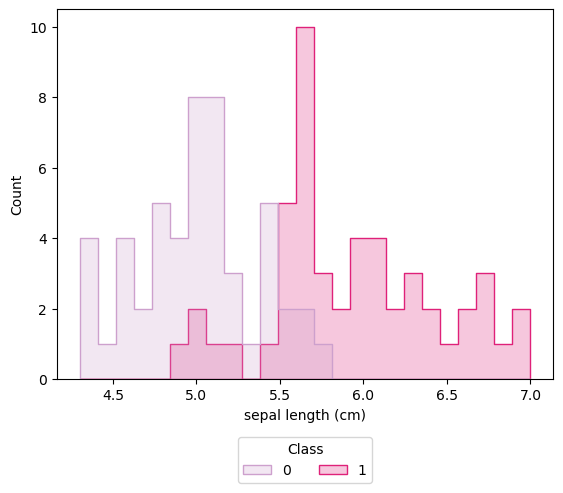

In [68]:
df = pd.concat([class_0, class_1])
ax = sns.histplot(data=df, 
                  x=iris.columns[0], # Selects the first column of df for x
                  hue="target", # Groups df by the target column and colours each group differently
                  element="step", # Specifies how we view the histogram. What other element options are there?
                  bins=25, # Creates 25 uniform bins based on our data
                  palette='PuRd')
sns.move_legend(ax, title='Class',loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)


Notice how when we created `df` we used the `pd.concat()` function, but did not specify an **axis**. That is because, by default, `pd.concat()` concatenates DataFrames along `axis=0` which is what we wanted to do when creating `df`.

In [69]:
# CHALLENGE: How else might you make df from the iris dataset? Hint: can you filter the iris DataFrame to include rows where target=0 OR target=1?



### 1.2 Use your histogram to roughly determine if your data is normally distributed

Based on the histogram above, it looks like sepal length is approximately normally distributed in each class.

**Understanding the Normal Distribution**

The **normal distribution** is a foundational concept in probability and statistical theory. It describes how the probability of data points is distributed.
- the **x-axis** represents the values of the data, and 
- the **y-axis** represents the probability of each data point, from 0 to 1.
The highest point on the normal distribution curve represents the value with the highest probability of occuring. It corresponds to the **mean** in statistical contexts. As you move away from the mean in either direction, the probability decreases symmetrically, forming the familiar bell-shaped curve.

**Comparing Two Distributions**

When comparing two normal distributions:
- **No overlap**: the two distributions likely represent two distinct datasets.
- **Complete overlap**: the two distributions may represent the same dataset and there is no real difference in the means of the distributions.
- **Partial overlap**: it is more difficult to determine whether or not the datasets are distinct. Further analysis is required.

**Why the Normal Distribution is Important**

The normal distribution is crucial in probability and statistics for two main reasons:
1. **The Central Limit Theorem (CLT):** as we collect more data, the sample mean becomes a better estimate of the true population mean
2. **The Three Sigma Rule:** describes how data is spread around the mean in a normal distribution
    - **68%** of data points will fall within **1 standard deviation** of the mean 
    - **95%** of data points will fall within **2 standard deviations** of the mean 
    - **99.7%** of data points will fall within **3 standard deviations** of the mean 

**Applying These Concepts to the Iris Dataset**

In the context of our iris dataset, we can use the Three Signma Rule to:
- measure the spread of a specific feature (ie. sepal length) across different classes 
- quantify how likely it is that the sepal length for one class differs significantly from another.

### 1.3 Create a Null and Alternate Hypothesis

This will allow us to carry out hypothesis testing.

**QUESTION:** Is the sepal length different between classes 0 and 1?
- **Null Hypothesis**: Sepal length *is not* different between classes 
- **Alternate Hypothesis**: Sepal length *is* different between classes

### 1.4 Hypothesis Testing

Returning to [this article](https://towardsdatascience.com/hypothesis-testing-in-machine-learning-using-python-a0dc89e169ce), we are reminded that there are several different statistical tests that can be conducted to test a hypothesis.

**In this case,** we want to test whether the means of two independent groups are statistically different or not. Thus, we will be conducting a **two sample, two-tailed hypothesis test**.

We are assuming that our data is normally distributed, but, since the sample size for each group exceeds 30, this assumption is less critial due to the CLT. Therefore, we will perform a **z-test** using each sample's **mean** and **standard deviation**.

First, let's calculate the mean and standard deviation of the sepal length of each class of iris.

In [70]:
col = df.columns[0] # Selecting only the first column in our DataFrame
print(col+" in two classes")
print("Class 0: mean {}, std {}".format(round(class_0[col].mean(), 3), round(class_0[col].std(), 3)))
print("Class 1: mean {}, std {}".format(round(class_1[col].mean(), 3), round(class_1[col].std(), 3)))

sepal length (cm) in two classes
Class 0: mean 5.006, std 0.352
Class 1: mean 5.936, std 0.516


These values look very similar! But let's calculate the z-test statistic before making any final decisions.

In [71]:
from statsmodels.stats.weightstats import ztest

*N.B. you can learn more about using the statsmodels z-test [here](https://www.statsmodels.org/dev/generated/statsmodels.stats.weightstats.ztest.html)*

This method requires the feature columns to be in arrays.

In [72]:
class_0 = class_0[col].values
class_1 = class_1[col].values

Finally, we can calculate the test-statistic and p-value:

using `ztest()`:
- `class_0` and `class_1` are the two datasets being compared
- `value=0` specifies the null hypothesis which assumes that there is **no difference** between the means of the two groups 
- `alternative='two-sided'` defines the type of hypothesis test. A **two-sided test** checks for differences in either direction rather than one specific direction

In [73]:
z_stat, p_val = ztest(class_0, class_1, value=0, alternative='two-sided') 

print(f"test-statistic (z-value): {z_stat}")
print(f"p-value: {p_val}")

test-statistic (z-value): -10.52098626754911
p-value: 6.91459526120739e-26


The **p-value** helps determine whether to accept or reject the null hypothesis. It measures the probability of observing the given data (or something more extreme) if the null hypothesis were true. We call this **statistical significance** 

Since decisions cannot be made with 100% certainty, we set a threshold for significance, typically at 5% (0.05):
-  If the p-value is **greater than 0.05**, we **fail to reject the null hypothesis**, indicating there is insufficient evidence to conclude a difference between the samples.
- if the p-value is **less than 0.05**, we **reject the null hypothesis**, indicating a statistically significant difference exists between the samples.

**In this case,** we **reject the null hypothesis**. The sepal length is different between classes 0 and 1.

And that's it! You've now learnt the basics of hypothesis testing.

## 2. Bayesian Theory

The second part of this tutorial will focus on Bayesian theory.

Now, as you will have learnt in your lectures, **Naive Bayes** methods are a set of supervised learning classifiers that operate under the assumption that the presence of one feature in a class is independent of the presence of any other feature.

There are several types of Naive Bayes models (learn more [here](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes)) but for this exercise, we will focus on **[Gaussian Naive Bayes classifiers](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)**.

For this, we will create our own dataset of **10 features** across **500 instances**, categorised into **two classes**: 
- **Class 0** represents a control group
- **Class 1** represents the class of interest. 
As in real world medical problems, there are fewer isntances of the class of interest.

*Learn more about making your own classification datasets [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)*

In [74]:
features, labels = datasets.make_classification(n_samples=500,      # Total number of samples to generate
                                                n_features=10,      # Number of features in the dataset
                                                n_informative=8,    # Number of features that carry useful information
                                                n_classes=2,        # Number of classes
                                                weights=np.array([0.65, 0.35]), # Proportion of samples in each class
                                                flip_y=0.01,        # Fraction of samples to randomly flip (introduces noise)
                                                class_sep=2.0,      # Separability of classes - larger=more distinct
                                                shuffle=True,       # Shuffle dataset after generation
                                                random_state=42)

Now, let's take a quick look at the features and labels that were generated, in dataframe form for ease.

In [75]:
features = pd.DataFrame(features)
labels = pd.DataFrame(labels)
df = pd.concat([features, labels], axis=1)
df.columns = ["F"+str(i) for i in range(10)] + ['Class']
df

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,Class
0,2.899136,-1.504262,-2.865578,3.189817,1.734764,2.105161,-3.229556,2.403973,-2.902707,0.499130,0
1,3.467613,-4.406937,2.849073,1.153019,2.711802,-1.961105,-2.671268,1.039823,-1.566765,-0.077519,1
2,3.644711,-0.110035,6.222994,-2.802069,-2.520034,2.023644,0.552524,1.413821,-1.214413,-2.570579,0
3,6.766245,-1.878676,-2.187759,9.928311,1.398671,-1.391950,-5.457044,-0.512490,-1.123277,1.302933,0
4,0.310887,-2.485219,2.607958,-1.757280,1.853096,-0.287983,-1.154815,1.309090,-2.093734,2.235665,1
...,...,...,...,...,...,...,...,...,...,...,...
495,0.218707,0.491198,-1.439844,-1.414677,1.648513,3.248171,-2.144993,3.165031,-1.861948,0.788817,0
496,4.153598,-0.616152,1.543311,0.248600,-1.944762,0.097494,2.932468,-0.694211,-1.438984,-0.710786,0
497,-2.801126,-4.375751,-2.436777,5.271192,-1.857045,-4.107250,-2.672585,1.632947,-2.407046,2.527889,1
498,2.770104,-1.092493,0.798509,1.294682,4.686547,-2.308703,-3.820610,0.356281,1.419128,1.836637,1


Now, as we are working with Naive Bayes classifer, we do not need to do any feature scaling, so let's get straight into building our model. 

First, we must split our data into training and testing data.

In [76]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state = 42)

Next, we need to import and build our model.

In [77]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB(var_smoothing=0.5)

In [78]:
y_train = y_train.values.reshape(-1) # converts the DataFrame to a 1D array

GNB.fit(x_train, y_train) # fits the model on the training data
y_pred = GNB.predict(x_test) # predicts labels on the test data
y_pred_probs = GNB.predict_proba(x_test) # predicted probability of each class on the test data

Now, we want to evaluate the performance of the classification model.

In [79]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [80]:
f1 = f1_score(y_test, y_pred,average=None)
recall = recall_score(y_test, y_pred,average=None)
precision = precision_score(y_test, y_pred,average=None)


print('\nf1:\t\t',f1)
print('recall\t\t',recall)
print('precision\t',precision)

print('\nf1_avg:\t\t',f1.mean())
print('recall_avg\t',recall.mean())
print('precision_avg\t',precision.mean())

print('\nf1_sd:\t\t',f1.std())
print('recall_sd\t',recall.std())
print('precision_sd\t',precision.std())

print('\n',classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred_probs[:,1]))


f1:		 [0.87671233 0.66666667]
recall		 [0.98461538 0.51428571]
precision	 [0.79012346 0.94736842]

f1_avg:		 0.7716894977168949
recall_avg	 0.7494505494505495
precision_avg	 0.8687459389213774

f1_sd:		 0.1050228310502283
recall_sd	 0.23516483516483522
precision_sd	 0.07862248213125406

               precision    recall  f1-score   support

           0       0.79      0.98      0.88        65
           1       0.95      0.51      0.67        35

    accuracy                           0.82       100
   macro avg       0.87      0.75      0.77       100
weighted avg       0.85      0.82      0.80       100

0.9516483516483516


Now, these scores are not very good, particularly when it comes to identifying the class of interest (Class 1). So how can we improve model performance?

One method is to **tune the hyperparameters** of the model (read more about this [here](https://medium.com/analytics-vidhya/how-to-improve-naive-bayes-9fa698e14cba))

For this, we first need to import the sklearn GridSearchCV function. This functions runs through all the different parameters fed into the parameter grid and produces the best combination of parameters based on a chosen scoring metric.

Learn more about how to use this function [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [81]:
from sklearn.model_selection import GridSearchCV

Next, we need to set the range of all the parameters we will feed into the parameter grid. For a Gaussian Naive Bayes classifier, the only parameter to tune is `var_smoothing`, which represents a stability calculation to widen (or smooth) the curve and therefore account for more samples that are further away from the distribution mean.

In [82]:
param_grid_nb = {'var_smoothing': np.logspace(0,-9, num=1000)} 

`np.logspace` returns numbers spaced evenly on a log scale, in the above example, we create a list of: 1000 samples starting from 0 and ending at -9 

Now, we build the GridSearchCV, using the model and parameter grid. We then fit this searching tool to the training data using a 10-fold cross-validation to find an optimal combination of hyperparameters that minimizes a predefined loss function to give better results.

In [83]:
GNB_Grid = GridSearchCV(estimator=GaussianNB(var_smoothing=0.5), 
                        param_grid=param_grid_nb, 
                        verbose=1, 
                        cv=10, 
                        n_jobs=-1)
GNB_Grid.fit(x_train, y_train)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


GridSearchCV(cv=10, estimator=GaussianNB(var_smoothing=0.5), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 9.79469667e-01, 9.59360829e-01, 9.39664831e-01,
       9.20373200e-01, 9.01477631e-01, 8.82969996e-01, 8.64842328e-01,
       8.47086827e-01, 8.29695852e-01, 8.12661920e-01, 7.95977700e-01,
       7.79636013e-01, 7.63629826e-01, 7.47952252e-01, 7.32596543e-01,
       7.1755...
       1.61141428e-09, 1.57833141e-09, 1.54592774e-09, 1.51418933e-09,
       1.48310251e-09, 1.45265393e-09, 1.42283046e-09, 1.39361927e-09,
       1.36500781e-09, 1.33698374e-09, 1.30953502e-09, 1.28264983e-09,
       1.25631660e-09, 1.23052400e-09, 1.20526094e-09, 1.18051653e-09,
       1.15628013e-09, 1.13254132e-09, 1.10928986e-09, 1.08651577e-09,
       1.06420924e-09, 1.04236067e-09, 1.02096066e-09, 1.00000000e-09])},
             verbose=1)

In [84]:
print(GNB_Grid.best_estimator_)

GaussianNB(var_smoothing=0.12305240043592616)


Now we want to re-evaluate the model on the test data.

In [85]:
grid_pred = GNB_Grid.predict(x_test)
grid_pred_probs = GNB_Grid.predict_proba(x_test) # predicted probability of each class on the test data

In [86]:
f1 = f1_score(y_test, grid_pred,average=None)
recall = recall_score(y_test, grid_pred,average=None)
precision = precision_score(y_test, grid_pred,average=None)


print('\nf1:\t\t',f1)
print('recall\t\t',recall)
print('precision\t',precision)

print('\nf1_avg:\t\t',f1.mean())
print('recall_avg\t',recall.mean())
print('precision_avg\t',precision.mean())

print('\nf1_sd:\t\t',f1.std())
print('recall_sd\t',recall.std())
print('precision_sd\t',precision.std())

print('\n',classification_report(y_test, y_pred))
print(roc_auc_score(y_test, grid_pred_probs[:,1]))


f1:		 [0.89552239 0.78787879]
recall		 [0.92307692 0.74285714]
precision	 [0.86956522 0.83870968]

f1_avg:		 0.8417005879692447
recall_avg	 0.832967032967033
precision_avg	 0.8541374474053296

f1_sd:		 0.05382180009045684
recall_sd	 0.09010989010989012
precision_sd	 0.015427769985974726

               precision    recall  f1-score   support

           0       0.79      0.98      0.88        65
           1       0.95      0.51      0.67        35

    accuracy                           0.82       100
   macro avg       0.87      0.75      0.77       100
weighted avg       0.85      0.82      0.80       100

0.9665934065934065


Now, these scores are much better!

And there you have it! You've now built and tuned your first Bayesian classifer.

Now you've finished this tutorial, follow the instructions and complete the assessment.